# GTD2 notebook

## 1. Adat és módszer

**Feladatunk a terrorizmus tulajdonságainak kontintens- és országfüggőségének vizualizálása, valamint a terrorcselekmények klasszifikációja az áldozatok száma alapján.**

GTD2 adatkészlet esetén terrorizmus az a cselekmény, melyre az alábbi pontok közül legalább kettő teljesül:
1. Az erőszakos cselekedet célja egy politikai, gazdasági, vallási vagy társadalmi cél elérése volt.
2. Az erőszakos cselekedet során egyértelmű volt a szándékos kényszerítés, megfélemlítés, vagy valamely más üzenet közvetítése egy nagyobb közönségnek, nem csak az áldozatoknak.
3. Az erőszakos cselekedet során sérültek a nemzetközileg elismert emberi jogok.

Az adatok 1970 és 2016 között történt terrorcselekményeket tartalmazzák. 1970-től 1997-ig rendszeresen frissítették, utána 2007-ig viszont visszamenőleg vitték fel az ismert támadásokat. Ezáltal valószínűleg ez az időszak nem adja vissza a teljes képet. 2007 után újra bekerültek az aktuális történések.

A forrás részletes információkat tartalmaz az
* esemény idejéről, hosszáról
* incidensről (definíció szerinti értelmezése alapján)
* incidens helyéről
* támadásról (típusa, sikeressége)
* fegyverről (típusa, altípusa)
* célpontról/áldozatról (típusa, specifikussága, nemzeti jellege)
* elkövetőről (csoport, létszám, bizonyosság) 
* veszteségekről és következményekről (halálos áldozatok száma, sérültek száma, anyagi kár, túszok)
* egyéb információkról és forrásokról

---

## 2. EDA

### 2.1 Adatok beolvasása

Spark python könyvtár importálása, majd a spark környezet `sc` létrehozása lokál módban.

In [2]:
from pyspark import SparkContext
from pyspark.sql import SQLContext

sc = SparkContext('local', 'gtd2')
sqlc = SQLContext(sc)

Az adatokat `gtd.txt` tabulátorral elválasztott szöveges fájlból olvassuk ki. Majd egy `map` segítségével tagoljuk a tabulátor alapján az oszlopokat.

In [3]:
raw = sc.textFile("gtd.txt")
data = raw.map(lambda x: x.split('\t'))

# Segéd függvény, amely az adatnak az oszlop indexét adja vissza az oszlopnév alapján
def getIndexByKey(key):
    return data.take(1)[0].index(key)

### 2.2 Terrorcselekmények számának év szerinti összesítése

In [3]:
import pandas as pd

iyear = getIndexByKey('iyear')
rdd_years = data.map(lambda x: (x[iyear], 1))\
                .reduceByKey(lambda a, b: a+b)\
                .filter(lambda x: x[0]!='iyear')\
                .sortByKey(1)

years = rdd_years.collect()
df_years = pd.DataFrame.from_records(years, columns = ('year', 'count')).apply(pd.to_numeric)

A `df_years` tartalmazza az egyes években összesített terrorcselekmények számát. A `df_years_kill` változóban pedig az összes haláleset található évekre lebontva.

In [13]:
nkill = getIndexByKey('nkill')
rdd_years_kills = sc.parallelize(data).map(lambda x: (x[iyear], x[nkill]))\
                      .filter(lambda x: x[0]!='iyear')\
                      .sortByKey(1)
        
df_years_kill = pd.DataFrame.from_records(rdd_years_kills.collect(), columns = ('year', 'killed')).apply(pd.to_numeric)
df_years_kill = df_years_kill.groupby('year')\
                             .sum()\
                             .reset_index()

TypeError: 'PipelinedRDD' object is not iterable

Statisztikai adatok számításához lesz rá szükség. TODO

In [5]:
from pyspark.mllib.stat import Statistics
import numpy as np
summary_year = Statistics.colStats(rdd_years)

In [6]:
print('46 év alatt átlagosan ennyi haláleset történt: ', df_years_kill['killed'].mean())
print(int(df_years_kill.max()['year']),'-ban/-ben történt a legtöbb (',int(df_years_kill.max()['killed']),') haláleset')

46 év alatt átlagosan ennyi haláleset történt:  8338.13043478
2016 -ban/-ben történt a legtöbb ( 43566 ) haláleset


### 2.3 Terrorcselekmények az országokban
#### 2.3.1 Incidensek száma az országokban
Az `incidents_in_countries`-ban találhatóak az összes terrorcselekmény száma országokra bontva. Az első öt legtöbb terrorcselekményt tartalmazó ország megjelenítése.

In [7]:
country_txt = getIndexByKey('country_txt')
incidents_in_countries = data.map(lambda x: (x[country_txt], 1)).reduceByKey(lambda a,b: a+b)
incidents_in_countries = incidents_in_countries.map(lambda x: (x[1], x[0])).sortByKey(0)
incidents_in_countries.take(5)

[(22130, 'Iraq'),
 (13634, 'Pakistan'),
 (11306, 'Afghanistan'),
 (10978, 'India'),
 (8163, 'Colombia')]

#### 2.3.2 Halálesetek száma az egyes országokban

In [14]:
import pandas as pd

country = getIndexByKey('country_txt')
nkill = getIndexByKey('nkill')

rdd_country_kill = data.map(lambda x: (x[country], x[nkill]))\
                       .filter(lambda x: x[0]!='country_txt')\
                       .sortByKey(1)

country_kill = rdd_country_kill.collect()
df_country_kill = pd.DataFrame.from_records(country_kill, columns = ('country', 'killed'))
df_country_kill['killed'] = df_country_kill['killed'].apply(pd.to_numeric)
df_country_kill = df_country_kill.groupby('country').sum().reset_index()
df_country_kill

,country,killed
0,Afghanistan,33146.0
1,Albania,42.0
2,Algeria,11091.0
3,Andorra,NaN
4,Angola,3036.0
5,Antigua and Barbuda,NaN
6,Argentina,489.0
7,Armenia,37.0
8,Australia,19.0
9,Austria,28.0


### 2.4 Halálesetek száma régiókra vetítve

In [9]:
import pandas as pd

region = getIndexByKey('region')
nkill = getIndexByKey('nkill')
rdd_region_kill = data.map(lambda x: (x[region], x[nkill]))\
                      .filter(lambda x: x[0]!='region')\
                      .sortByKey(1)

region_kill = rdd_region_kill.collect()
df_region_kill = pd.DataFrame.from_records(region_kill, columns = ('region', 'killed')).apply(pd.to_numeric)
#df_region_kill['killed'] = df_region_kill['killed'].apply(pd.to_numeric)
df_region_kill = df_region_kill.groupby('region').sum().reset_index()
df_region_kill

,region,killed
0,1,4764.0
1,2,28704.0
2,3,28730.0
3,4,1138.0
4,5,14819.0
5,6,93434.0
6,7,993.0
7,8,6595.0
8,9,7311.0
9,10,125676.0


---

## 3. Vizualizációk

### 3.1 Terrorcselekmények időbeli trendje
Az alábbi vizualizációs blokk egy egyszerű idősor diagram, amely ábrázolja, hogy egy évben mennyi terrorcselekmény történt, és az évek során hány halálos áldozat volt.

In [82]:
from math import log10
from matplotlib import pyplot as plt
import numpy as np

lg_counts = df_years['count'].apply(log10)
m, b = np.polyfit(df_years['year'], df_years['count'], 1)

fig = plt.figure()

pl1 = fig.add_subplot(211)
pl1.set_ylabel('Terrorcselekmények száma')
pl1.set_title('Halálesetek és terrorcselekmények száma 1970-2016')
plt.yscale('linear')
pl1.plot(df_years['year'], df_years['count'])
pl1.plot(df_years['year'], m*df_years['year']+b, '-')

pl2= fig.add_subplot(212)
pl2.set_ylabel('Halálesetek száma')
pl2.set_xlabel('years')
plt.yscale('log')
pl2.plot(df_years_kill['year'], df_years_kill['killed'])

plt.show()

NameError: name 'df_years' is not defined

 ### 3.2 Terrortámadások denzitása

Az alábbi vizualizációs blokk az összes terrorcselekményt ábrázolja a hosszúsági és szélességi adatok alapján.
A vizualizációhoz elsősorban a *datashader* könyvtárat használjuk. A codebook alapján, a hosszúsági és szélességi adatok WGS84-es formátumba vannak tárolva, viszont ahhoz, hogy megfelelően tudjuk ábrázolni a pontokat, WebMercator formátumba kell  projektálni a meglévő hosszúsági és szélességi adatokat. Ehhez a *pyproj* nevű könyvtárat használjuk. Ehhez egy-egy  függvényt (*toWebMLon* és *toWebMLat*) definiáltunk, ami megvalósítja a megfelelő projekciókat. A pozíciókat a *pandas* könyvtár segítségével egy dataframe-be tároljuk, amit feltudunk használni a vizualizációhoz. Az ábrán fekete alapra egy 
"hőtérkép"-hez hasonló eredményt várunk, vagyis adott térségben lévő színfoltok fogják jellemezni a terror cselekmények helybeli sűrűségét.

Később a *datashader* könyvtárat arra fogjuk használni, hogy kontinensekre, ill. országokra vetítve ábrázoljuk a terrorcselekmények számát. Minél több terrortámadás történt egy kontinensen vagy egy országban, az annál világosabb színt kap.

In [70]:
from pyproj import Proj, transform
import pandas as pd

# long/lat. adatok Web mercator formátumba konvertálásához
def toWebMLon(lon):
    loc = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), lon, 0)
    return loc[0]

def toWebMLat(lat):
    loc = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), 0, lat)
    return loc[1]

# indexek
longitude = getIndexByKey('longitude')
latitude = getIndexByKey('latitude')
successful = getIndexByKey('success')
attack_type = getIndexByKey('attacktype1')
weapon_type = getIndexByKey('weaptype1_txt')

points = data.map(lambda x: (x[longitude], x[latitude], x[successful], x[attack_type], x[weapon_type]))\
             .filter(lambda x: x[0]!='longitude')\
             .collect()

locations = pd.DataFrame.from_records(points, columns = ['longitude', 'latitude', 'success', 'attack', 'weapon']).replace({',': '.'}, regex=True)
locations['longitude'] = locations['longitude'].apply(pd.to_numeric)
locations['latitude'] = locations['latitude'].apply(pd.to_numeric)

locations['longitude'] = locations['longitude'].apply(toWebMLon)
locations['latitude'] = locations['latitude'].apply(toWebMLat)

/opt/conda/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


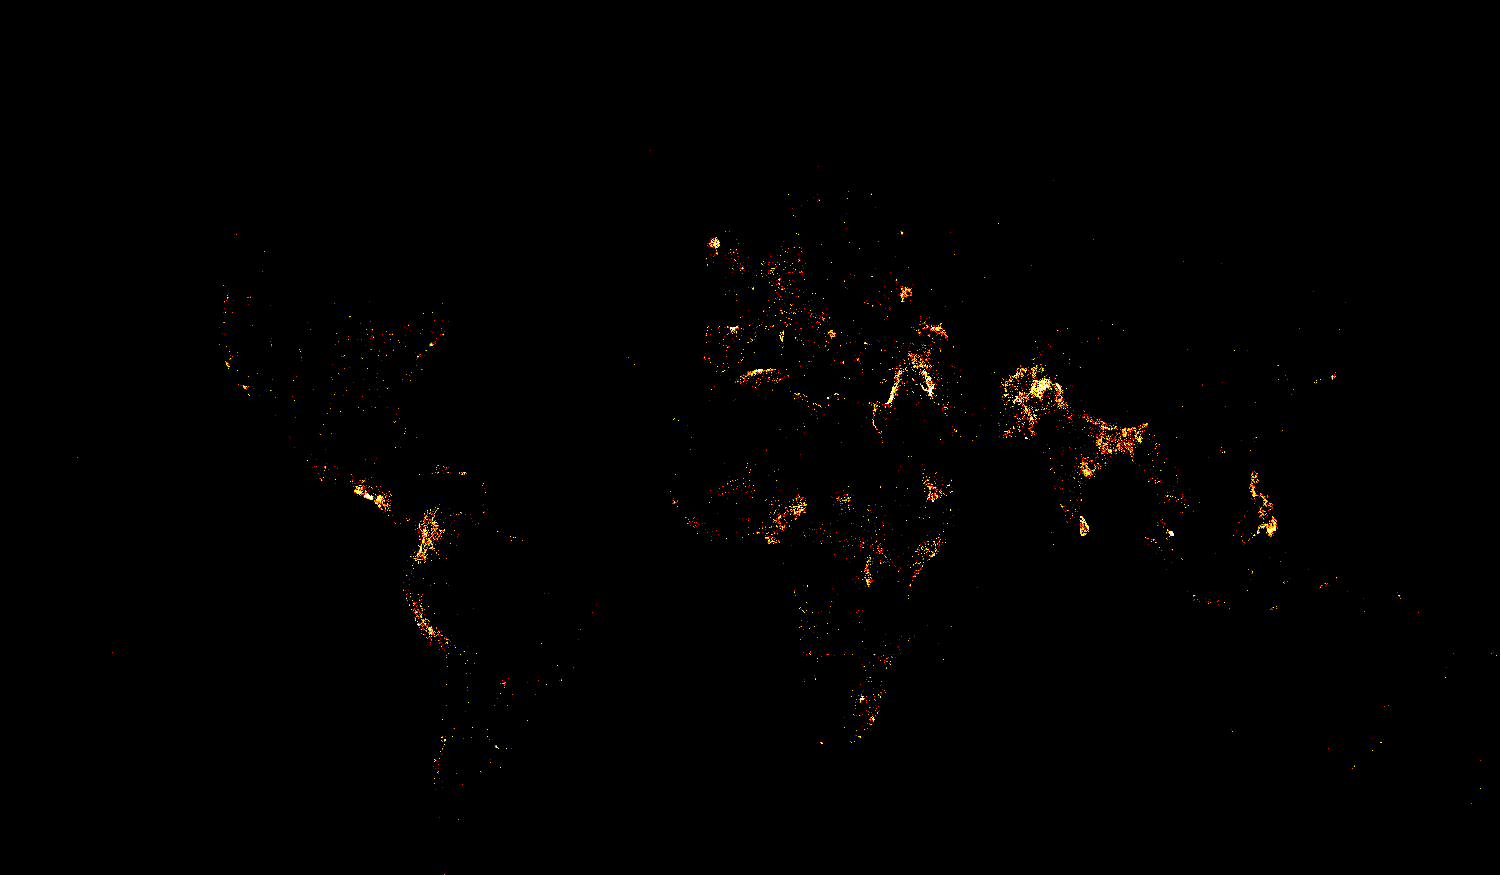

In [44]:
import datashader as ds
import datashader.glyphs
import datashader.transfer_functions as tf
from functools import partial
from datashader.utils import export_image
from matplotlib.cm import hot

background = "black"
export = partial(export_image, background = background, export_path="export")

x_range = (locations['longitude'].min(), locations['longitude'].max())
y_range = (locations['latitude'].min(), locations['latitude'].max())

plot_width  = int(1500) # Minél nagyobb, annál jobb a felbontás, akár országon belüli eloszlás vizsgálatához
plot_height = int(plot_width*7.0/12)

# Terrorcselekmények denzitása
cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height, x_range=x_range, y_range=y_range)
agg = cvs.points(locations, 'longitude', 'latitude') 
export(tf.shade(agg, cmap = hot, how='eq_hist'), "gtd_on_map")

In [80]:
if background == "black":
      color_key = {'1':'red', '0':'green'}
else: color_key = {'1':'red', '0':'green'}

cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height, x_range=x_range, y_range=y_range)
agg = cvs.points(locations, 'longitude', 'latitude', ds.count_cat('weapon'))

export(tf.shade(agg, color_key=color_key, how='eq_hist'), "successful attacks")

ValueError: input must be categorical

### 3.3 Terrorcselekmények kontines és országfüggősége

A terrorcselekmények számát régiókra összesítettük a `df_region_kill` dataframe-ben.

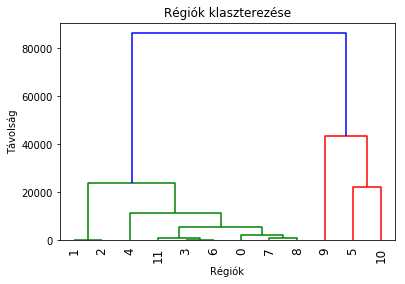

Cophenetic korráliciós együttható 0.914332921888


In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

from matplotlib import pyplot as plt

Z = linkage(df_region_kill, 'average')

plt.title('Régiók klaszterezése')
plt.xlabel('Régiók')
plt.ylabel('Távolság')
dendrogram(Z, leaf_rotation=90)
plt.show()

c, coph_dists = cophenet(Z, pdist(df_region_kill))
print("Cophenetic korráliciós együttható", c)

---

## 4. Klasszifikáció  

Klasszifikálnunk kell az incidenseket az áldozatok száma alapján. Alkothatnánk például 4 osztályt a percentilisek alapján. Ne nekünk kelljen megmondani, hogy 10 alatt kevésnek számít, 100 felett meg soknak. Beszéljenek a számok! Ha pl az adatkészlet alapján az esetek 25%-ában kevesebben haltak meg 20-nál, 20 legyen a legkevesebb áldozatot jelölő osztály.

In [83]:
from matplotlib import pyplot as plt
import numpy as np

nkill_column = data.map(lambda x: [x[nkill]]).filter(lambda x: x[0]!='nkill' and x[0]!='')
df = pd.DataFrame(nkill_column.collect(),columns=['nkill']).apply(pd.to_numeric)
df.quantile([0.25,0.5,0.75,1])

,nkill
0.25,0.0
0.50,0.0
0.75,2.0
1.00,1500.0


Hmm, ez fura. Vajon hogyan alakul az áldozatok száma az összes incidens esetén?

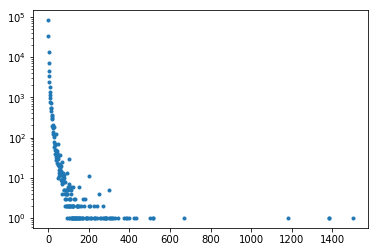

In [100]:
nkill_sum = data.map(lambda x: (x[nkill], 1)).filter(lambda x: x[0]!='nkill' and x[0]!='').reduceByKey(lambda a,b: a+b).sortByKey(1)
df2 = pd.DataFrame(nkill_sum.collect(), columns=['nkills','sum']).apply(pd.to_numeric)

plt.plot(df2['nkills'], df2['sum'], '.')
plt.yscale('log')
plt.show()

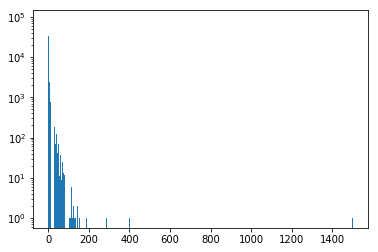

In [101]:
plt.bar(df2['nkills'], df2['sum'])
plt.yscale('log')
plt.show()

ÁHÁ! Így már jobban tudunk gondolkodni, hogyan osszuk be az osztályainkat sávokra. A percentilis ötlete nem jött be. :D

In [17]:
def getClassLabel(number):
    borders = (1,5,10,100) # i. oszályba tartozik egy incidens, ha a tömb i. indexű eleménél kevesebb áldozata volt
    for i in range(len(borders)):
        if int(number)<borders[i]:
            return i+1
    return len(borders)+1

nkill_classes = data.map(lambda x: x[nkill]).filter(lambda x: x!='nkill' and x!='').map(lambda x: (getClassLabel(x), 1)).reduceByKey(lambda a,b: a+b).sortByKey(1)
nkill_classes.collect()

[(1, 82925), (2, 59253), (3, 9892), (4, 8391), (5, 207)]

In [88]:
locations['weapon'] = locations['weapon'].astype('str')
type(locations['weapon'])

pandas.core.series.Series

In [79]:
locations

,longitude,latitude,success,attack,weapon
0,-7.786928e+06,2.091085e+06,1,1,Unknown
1,-1.103546e+07,2.205935e+06,1,6,Unknown
2,1.342510e+07,1.744419e+06,1,1,Unknown
3,2.641406e+06,4.577134e+06,1,3,Explosives/Bombs/Dynamite
4,1.451566e+07,3.972600e+06,1,7,Incendiary
5,-9.927057e+06,4.439818e+06,1,2,Firearms
6,-6.254732e+06,-4.149099e+06,0,1,Firearms
7,-1.361137e+07,4.551925e+06,1,3,Explosives/Bombs/Dynamite
8,-9.953353e+06,5.323637e+06,1,7,Incendiary
9,-9.950481e+06,5.323082e+06,1,7,Incendiary
